# Part I. ETL Pipeline for Pre-Processing the Files

## PLEASE RUN THE FOLLOWING CODE FOR PRE-PROCESSING THE FILES

#### Import Python packages 

In [ ]:
import pandas as pd
import cassandra
import re
import os
import glob
import numpy as np
import json
import csv

#### Creating list of filepaths to process original event csv data files

In [ ]:
print(os.getcwd())

filepath = os.getcwd() + '/event_data'

for root, dirs, files in os.walk(filepath):
    file_path_list = glob.glob(os.path.join(root,'*'))
   

#### Processing the files to create the data file csv that will be used for Apache Casssandra tables

In [ ]:
# initiating an empty list of rows that will be generated from each file
full_data_rows_list = [] 
    
# for every filepath in the file path list 
for f in file_path_list:

# reading csv file 
    with open(f, 'r', encoding = 'utf8', newline='') as csvfile: 
        # creating a csv reader object 
        csvreader = csv.reader(csvfile) 
        next(csvreader)
        
 # extracting each data row one by one and append it        
        for line in csvreader:
            #print(line)
            full_data_rows_list.append(line) 

# Prints out how many files were processed: 
print(len(full_data_rows_list))

#uncomment the code below if you would like to see what the list of event data rows will look like
#print(full_data_rows_list)

# creating a smaller event data csv file called event_datafile_full csv that will be used to insert data into the \
# Apache Cassandra tables
csv.register_dialect('myDialect', quoting=csv.QUOTE_ALL, skipinitialspace=True)

with open('event_datafile_new.csv', 'w', encoding = 'utf8', newline='') as f:
    writer = csv.writer(f, dialect='myDialect')
    writer.writerow(['artist','firstName','gender','itemInSession','lastName','length',\
                'level','location','sessionId','song','userId'])
    for row in full_data_rows_list:
        if (row[0] == ''):
            continue
        writer.writerow((row[0], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[12], row[13], row[16]))

In [ ]:
# Number of rows in the final csv file
with open('event_datafile_new.csv', 'r', encoding = 'utf8') as f:
    print(sum(1 for line in f))

#### Creating a Cluster

In [ ]:
# Importing Cluster module to connect to Cassandra instance  locally (127.0.0.1)
from cassandra.cluster import Cluster
cluster = Cluster(['127.0.0.1'])

# Establishing connection to be able to execute queries:
session = cluster.connect()

#### Create Keyspace

In [ ]:
# Query to set up Keyspace: 
session.execute("""
    CREATE KEYSPACE IF NOT EXISTS udacity 
    WITH REPLICATION = 
    { 'class' : 'SimpleStrategy', 'replication_factor' : 1 }""")

#### Set Keyspace

In [ ]:
# Setting KEYSPACE to 'udacity'
session.set_keyspace('udacity')

### Modeling  database tables  on the below type of queries:

#### 1. Give me the artist, song title and song's length in the music app history that was heard during  sessionId = 338, and itemInSession  = 4
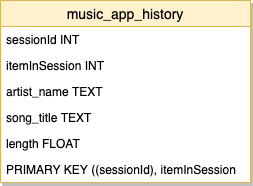

#### 2. Give me only the following: name of artist, song (sorted by itemInSession) and user (first and last name) for userid = 10, sessionid = 182
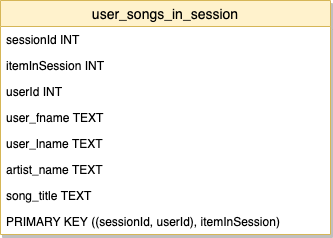  

#### 3. Give me every user name (first and last) in my music app history who listened to the song 'All Hands Against His Own'
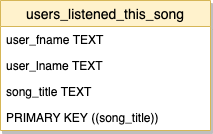

In [ ]:
## Creating table 'music_app_history' to perform Query 1(Give me the artist, song title and song's length in the music app history that was heard during \
## sessionId = 338, and itemInSession = 4)

query = "CREATE TABLE IF NOT EXISTS music_app_history"
query = query + "(sessionId INT, itemInSession INT, artist_name TEXT, song_title TEXT, length float, PRIMARY KEY ((sessionId), itemInSession))"

try:
    session.execute(query)
except Exception as e:
    print(e)
                    

In [ ]:
# We have provided part of the code to set up the CSV file. Please complete the Apache Cassandra code below#
file = 'event_datafile_new.csv'

# Openning CSV file for read and write to the table 'music_app_history'
with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) # skip header
    for line in csvreader:
        query = "INSERT INTO music_app_history (sessionId, itemInSession, artist_name, song_title, length)"
        query = query + "VALUES (%s, %s, %s, %s, %s)"
        session.execute(query, (int(line[8]), int(line[3]), line[0], line[9], float(line[5]))) # each column references to the column in CSV file
            
            

#### Do a SELECT to verify that the data have been inserted into each table

In [ ]:
# Running SELECT query to get expected data from music_app_history:

rows = session.execute('SELECT * FROM music_app_history WHERE sessionId=338 AND itemInSession=4')
for row in rows:
    print (row[0], row[1], row[2], row[3], row[4])


### COPY AND REPEAT THE ABOVE THREE CELLS FOR EACH OF THE THREE QUESTIONS

In [ ]:
# Creating table user_songs_in_session Query 2 (Give me only the following: name of artist, song (sorted by itemInSession) 
# and user (first and last name) for userid = 10, sessionid = 182)

query = "CREATE TABLE IF NOT EXISTS user_songs_in_session"
query = query + "(sessionId INT, itemInSession INT, userId INT, user_fname TEXT, user_lname TEXT, artist_name TEXT, song_title TEXT, PRIMARY KEY((sessionId, userId),itemInSession))"

try:
    session.execute(query)
except Exception as e:
    print(e)           
                    

In [ ]:
# Importing data from CSV to user_songs_in_session table:

file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) 
    for line in csvreader:
        
        query = "INSERT INTO user_songs_in_session (sessionId, itemInSession, userId, user_fname, user_lname, artist_name, song_title)"
        query = query + "VALUES (%s, %s, %s, %s, %s, %s, %s)"
        session.execute(query, (int(line[8]), int(line[3]), int(line[10]), line[1], line[4], line[0], line[9]))
            

In [ ]:
# Performing Query 2 with SELCT statement:
rows = session.execute('SELECT * FROM user_songs_in_session WHERE userid = 10 AND sessionid = 182')
for row in rows:
    print (row[0], row[1], row[2], row[3], row[4], row[5], row[6])
    

In [ ]:
# Creating table users_listened_this_song for Query 3 (Give me every user name (first and last) in my music app history who listened 
# to the song 'All Hands Against His Own')

query = "CREATE TABLE IF NOT EXISTS users_listened_this_song"
query = query + "(user_fname TEXT, user_lname TEXT,  song_title TEXT, PRIMARY KEY((song_title)))"

try:
    session.execute(query)
except Exception as e:
    print(e)
             

In [ ]:
# Importing data from CSV to users_listened_this_song table
file = 'event_datafile_new.csv'

with open(file, encoding = 'utf8') as f:
    csvreader = csv.reader(f)
    next(csvreader) 
    for line in csvreader:
        
        query = "INSERT INTO users_listened_this_song (user_fname, user_lname,  song_title)"
        query = query + "VALUES (%s, %s, %s)"
        session.execute(query, (line[1], line[4], line[9]))

In [ ]:
# Performing Query 3 with SELET statement: 
rows = session.execute("SELECT user_fname, user_lname FROM users_listened_this_song WHERE song_title ='All Hands Against His Own'")
for row in rows:
    print (row[0], row[1])
    

### Drop the tables before closing out the sessions

In [ ]:
# Drop the tables before closing out the sessions
query = "DROP TABLE music_app_history"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)

query = "DROP TABLE user_songs_in_session"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)

query = "DROP TABLE users_listened_this_song"
try:
    rows = session.execute(query)
except Exception as e:
    print(e)

### Close the session and cluster connection¶

In [ ]:
session.shutdown()
cluster.shutdown()